In [1]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
import tensorflow as tf


In [3]:
# load data
dataframe = pd.read_csv('/content/drive/MyDrive/Thub_netlist.csv', sep = r',',skipinitialspace=True)

/tmp/ipython-input-4002907640.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv('/content/drive/MyDrive/Thub_netlist.csv', sep = r',',skipinitialspace=True)


In [4]:
dataframe=dataframe.dropna(axis=1,how="any")
#dataframe=dataframe.drop(columns=['50'])
#dataframe.astype(float)
dataframe.fillna('mean', inplace=True)
dataframe = dataframe.dropna()
dataframe = dataframe.replace("'Trojan Infected'",1)
dataframe = dataframe.replace("'Trojan Free'",0)
#dataframe=dataframe.drop(columns=['50'])

In [5]:
arr=np.array(dataframe.values)
#X=arr[0:,1:48]
#X=X.astype('float')
#Y=(arr[0:,49]).astype('float')


X=arr[1:,0:48]
X=X.astype('float')
Y=(arr[1:,47]).astype('float')

In [6]:
# Scaling the data to make it suitable for the auto-encoder
X_scaled = MinMaxScaler().fit_transform(X)
X_normal_scaled = X_scaled[Y == 0]
X_fraud_scaled = X_scaled[Y == 1]


In [22]:
# Building the Input Layer
input_layer = Input(shape =(X.shape[1], ))

# Building the Encoder network
encoded = Dense(100, activation ='tanh',
				activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoded = Dense(75, activation ='tanh',
				activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation ='tanh',
				activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(25, activation ='tanh',
				activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(12, activation ='tanh',
				activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(10, activation ='tanh')(encoded)

# Building the Decoder network
decoded = Dense(12, activation ='tanh')(encoded)
decoded = Dense(25, activation ='tanh')(decoded)
decoded = Dense(50, activation ='tanh')(decoded)
decoded = Dense(100, activation ='tanh')(decoded)

# Building the Output Layer
output_layer = Dense(X.shape[1], activation ='relu')(decoded)


In [23]:
# Defining the parameters of the Auto-encoder network
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.001), loss ="binary_crossentropy")

# Training the Auto-encoder network
autoencoder.fit(X_normal_scaled, X_normal_scaled,
                                batch_size = 16, epochs = 50,
                                shuffle = True, validation_split = 0.20)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.6781 - val_loss: 0.4727
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.6577 - val_loss: 0.4364
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.6043 - val_loss: 0.4080
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.5435 - val_loss: 0.2433
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.4670 - val_loss: 0.1310
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.3859 - val_loss: 0.1302
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.3769 - val_loss: 0.1314
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 0.3718 - val_loss: 0.1256
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.3536 - val_loss: 0.1198
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.3414 - val_loss: 0.1117
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 0.3342 - val_loss: 0.1056
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.3161 - val_loss: 

In [24]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3])
hidden_representation.add(autoencoder.layers[4])


In [25]:
# Separating the points encoded by the Auto-encoder as normal and fraud
normal_hidden_rep = hidden_representation.predict(X_normal_scaled)
fraud_hidden_rep = hidden_representation.predict(X_fraud_scaled)

# Combining the encoded points into a single table
encoded_X = np.append(normal_hidden_rep, fraud_hidden_rep, axis = 0)
y_normal = np.zeros(normal_hidden_rep.shape[0])
y_fraud = np.ones(fraud_hidden_rep.shape[0])
encoded_y = np.append(y_normal, y_fraud)

# Plotting the encoded points
#tsne_plot(encoded_X, encoded_y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [26]:
# Splitting the encoded data for linear classification
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(encoded_X, encoded_y, test_size = 0.3)

# Splitting the original data for non-linear classification
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)


In [27]:
import numpy as np

# Count the occurrences of each unique value in y_test_encoded
unique_values, counts = np.unique(y_test_encoded, return_counts=True)

# Print the counts
print("Number of instances for each class in the encoded test data (y_test_encoded):")
for value, count in zip(unique_values, counts):
    print(f"Class {value}: {count}")

Number of instances for each class in the encoded test data (y_test_encoded):
Class 0.0: 6
Class 1.0: 267


In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_encoded, y_train_encoded)


RandomForestClassifier(random_state=42)

In [30]:
# Filter for instances of class 1 in the encoded test data
class_1_indices = np.where(y_test_encoded == 1.0)[0]
X_test_encoded_class_1 = X_test_encoded[class_1_indices]
y_test_encoded_class_1 = y_test_encoded[class_1_indices]

# Select the first 5 instances of class 1 (or fewer if there are less than 5)
num_samples_to_select = min(5, len(X_test_encoded_class_1))
X_test_encoded_subset = X_test_encoded_class_1[:num_samples_to_select]
y_test_encoded_subset = y_test_encoded_class_1[:num_samples_to_select]

# Use the trained Random Forest classifier to predict on the subset
y_pred_subset_rf = rf_classifier.predict(X_test_encoded_subset)

print(f"Selected {num_samples_to_select} instances of class 1 from the encoded test data.")
print("Actual labels:", y_test_encoded_subset)
print("Predicted labels by Random Forest classifier:", y_pred_subset_rf)

Selected 5 instances of class 1 from the encoded test data.
Actual labels: [1. 1. 1. 1. 1.]
Predicted labels by Random Forest classifier: [1. 1. 1. 1. 1.]


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=20, random_state=0)
rf_classifier.fit(X_train_encoded, y_train_encoded)

# Predict on the test set
y_pred_encoded_rf = rf_classifier.predict(X_test_encoded)

# Evaluate the model
print("Random Forest Classifier Results (Encoded Data):")
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_encoded_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred_encoded_rf))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_encoded_rf))

Random Forest Classifier Results (Encoded Data):
Accuracy: 1.0

Confusion Matrix:
 [[  6   0]
 [  0 267]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00       267

    accuracy                           1.00       273
   macro avg       1.00      1.00      1.00       273
weighted avg       1.00      1.00      1.00       273



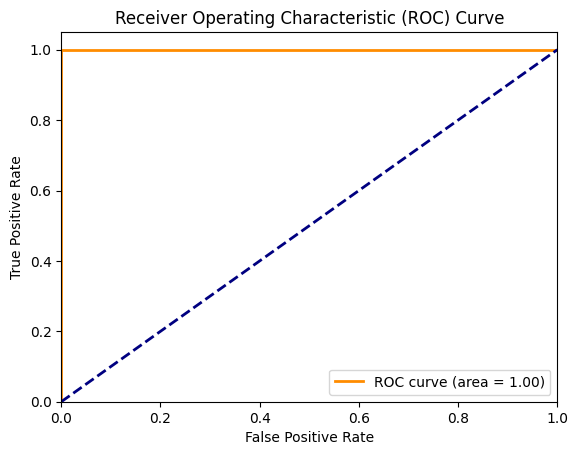

AUC: 1.00


In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class (class 1)
y_pred_proba_rf = rf_classifier.predict_proba(X_test_encoded)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba_rf)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.2f}")

In [33]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the base models
log_clf = LogisticRegression(random_state=42)
svm_clf = SVC(probability=True, random_state=42) # probability=True is needed for soft voting
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create the ensemble model using VotingClassifier (soft voting)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svc', svm_clf), ('rf', rf_clf)],
    voting='soft'  # Use 'soft' for probability-based voting
)

# Train the ensemble model on the encoded training data
voting_clf.fit(X_train_encoded, y_train_encoded)

# Predict on the encoded test data
y_pred_ensemble = voting_clf.predict(X_test_encoded)

# Evaluate the ensemble model
print("Ensemble Model Results (Logistic Regression, SVM, Random Forest) on Encoded Data:")
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_ensemble))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred_ensemble))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_ensemble))

Ensemble Model Results (Logistic Regression, SVM, Random Forest) on Encoded Data:
Accuracy: 1.0

Confusion Matrix:
 [[  6   0]
 [  0 267]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00       267

    accuracy                           1.00       273
   macro avg       1.00      1.00      1.00       273
weighted avg       1.00      1.00      1.00       273



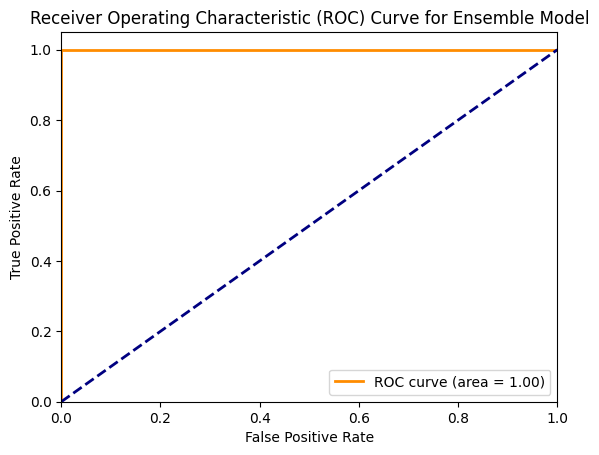

Ensemble Model AUC: 1.00


In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class (class 1) for the ensemble model
y_pred_proba_ensemble = voting_clf.predict_proba(X_test_encoded)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(y_test_encoded, y_pred_proba_ensemble)

# Calculate the AUC (Area Under the Curve) for the ensemble model
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

# Plot the ROC curve for the ensemble model
plt.figure()
plt.plot(fpr_ensemble, tpr_ensemble, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_ensemble)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Ensemble Model')
plt.legend(loc="lower right")
plt.show()

print(f"Ensemble Model AUC: {roc_auc_ensemble:.2f}")